In [169]:
%load_ext autoreload
%autoreload 2

import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import Compose, Normalize, Lambda, Resize

device = 'cuda'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [170]:
from data import CatDataset
from diffusion import Diffusion, get_named_beta_schedule
from trainer import Trainer
from models.unet import UNet

In [236]:
ds = CatDataset(
    'data/cats_256_aligned',
    transform = Compose([
        Lambda(lambda x: x.float()),
        Resize(64),
        Normalize(127.5, 127.5),
    ])
)

sample.shape torch.Size([3, 64, 64])
sample.min() tensor(-0.9941)
sample.max() tensor(1.)


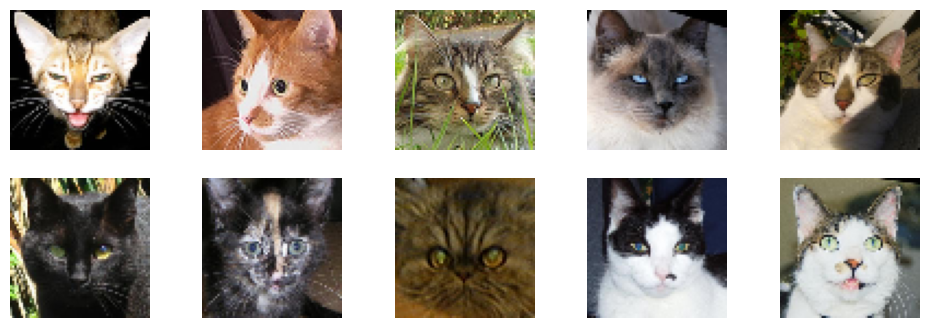

In [237]:
# Inspect dataset
indices = np.random.choice(len(ds), 10, replace=False)
fig, axes = plt.subplots(2, 5, figsize=(12, 4))
for i, ax in zip(indices, axes.flatten()):
    ax.imshow(ds[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
    ax.axis('off')

sample = ds[0]
print("sample.shape", sample.shape)
print("sample.min()", sample.min())
print("sample.max()", sample.max())


In [238]:
from models.vae import Encoder, Decoder, VAE

In [256]:
model = VAE(
    in_channels=3,
    base_channels=16,
    in_resolution=64,
    num_levels=4,
    latent_dim=64, 
    num_blocks_per_level=1,
    dropout=0.3
).cuda()

In [257]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("encoder parameters", count_parameters(model.decoder))
print("decoder parameters", count_parameters(model.encoder))

encoder parameters 1897155
decoder parameters 2551200


In [261]:
trainer = Trainer(
    model,
    ds.train_loader(batch_size=64),
    ds.test_loader(batch_size=4),
    lr=1e-3,
    weight_decay=1e-4,
    num_epochs=100000,
    log_every=1,
    save_every=100,
    device='cuda',
    checkpoint_file='checkpoints/checkpoint_16.pt'
)

In [262]:
trainer.run_loop(True)

 63%|██████▎   | 79/125 [00:20<00:12,  3.71it/s]

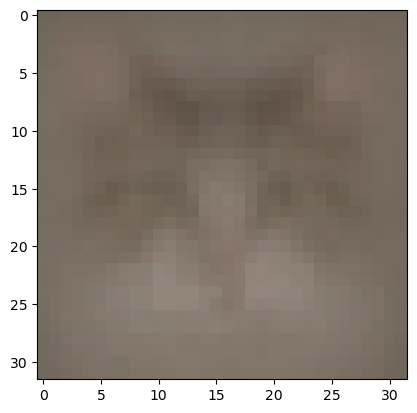

In [168]:
res = model.decoder(torch.randn(1, 128).cuda())
plt.imshow(res[0].permute(1, 2, 0).detach().cpu().numpy() * 0.5 + 0.5)

# Debug

In [11]:
model.eval()
x0 = ds[0][None].to(device)
noise = torch.randn_like(x0)
t = torch.tensor([500]).to(device).long()
x_t = diffusion.q_sample(x0, t, noise)
with torch.no_grad():
    x0_hat = model(x_t, t)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


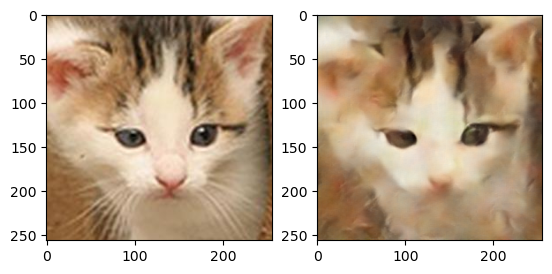

In [13]:
plt.subplot(1, 2, 1)
plt.imshow(x0[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
plt.subplot(1, 2, 2)
plt.imshow(x0_hat[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)

In [15]:
res = diffusion.p_sample_loop(model, (1, 3, 256, 256), device='cuda')

100%|██████████| 1000/1000 [00:25<00:00, 39.82it/s]


In [17]:
res.min(), res.max()

(tensor(-1.1973, device='cuda:0'), tensor(0.4419, device='cuda:0'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


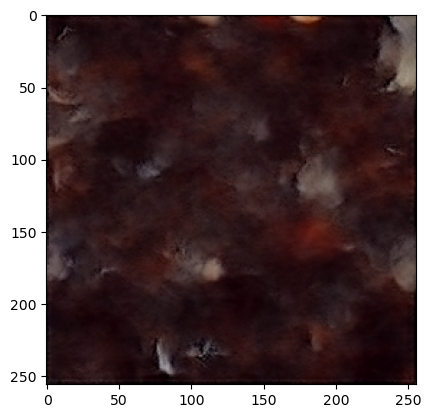

In [16]:
plt.imshow(res[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)